## 0. Import Libraries

In [2]:
from datetime import datetime, timedelta
from glob import glob

import numpy as np
import pandas as pd
import pyproj
import rioxarray
import salem
import xarray as xr
from shapely.geometry import mapping

import cartopy
import matplotlib.pyplot as plt
import proplot
from matplotlib.colors import BoundaryNorm, ListedColormap
import matplotlib
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader

import warnings
warnings.filterwarnings('ignore')

## 1. Data Options

In [105]:
variables = ['T2C', 'ACHFX', 'ACLHF']
general_path = 'data'
start_utc = 0
end_utc = 24

# ensemble members
micro_options = [
    'LIN',
    'THOMPSON',
    'WSM6'
]

luse_options = [
    'urban',
    'nourban'
]

## 2. Open and Merge Datasets

In [106]:
# dicts to accumulate data
dt_ens_mean = {}

# loop over seasons
for run_data in ['era5']:
    
    # dicts to accumulate data
    dt_ens_mean_var = []
    
    # loop over variables
    for variable in variables:
        
        # data path
        data_path = glob(fr'{general_path}/*{run_data}**{variable}*')

        # open data
        dt = xr.open_mfdataset(data_path,
                               concat_dim='ens').isel(time=slice(start_utc, end_utc))[variable]

        # instead of 201 grid we want 200 grid in each direction
        dt = dt.isel(south_north=slice(0,200),
                     west_east=slice(0,200))

        # assign projection and dim info
        dt = dt.rio.write_crs(dt.attrs['pyproj_srs'])
        dt = dt.rio.set_spatial_dims(x_dim='west_east',
                                     y_dim='south_north')

        # define ensemble members
        # ensemble member list
        ensemble_members = list(dt.ens.values)

        # urban and nourban members
        urban_members = [ens for ens in ensemble_members if not 'nourban' in ens ]
        nourban_members = [ens for ens in ensemble_members if 'nourban' in ens ]

        # calculate urban and nourban ensembles
        dt_urban_ens = dt.sel(ens=urban_members).mean(dim='ens')
        dt_nourban_ens = dt.sel(ens=nourban_members).mean(dim='ens')

        # find diff between urban and nourban ens means
        dt_ens_diff = dt_urban_ens - dt_nourban_ens

        dt_ens_mean_var.append(dt_ens_diff.mean(dim='time'))
        
    dt_ens_mean[run_data] = dt_ens_mean_var

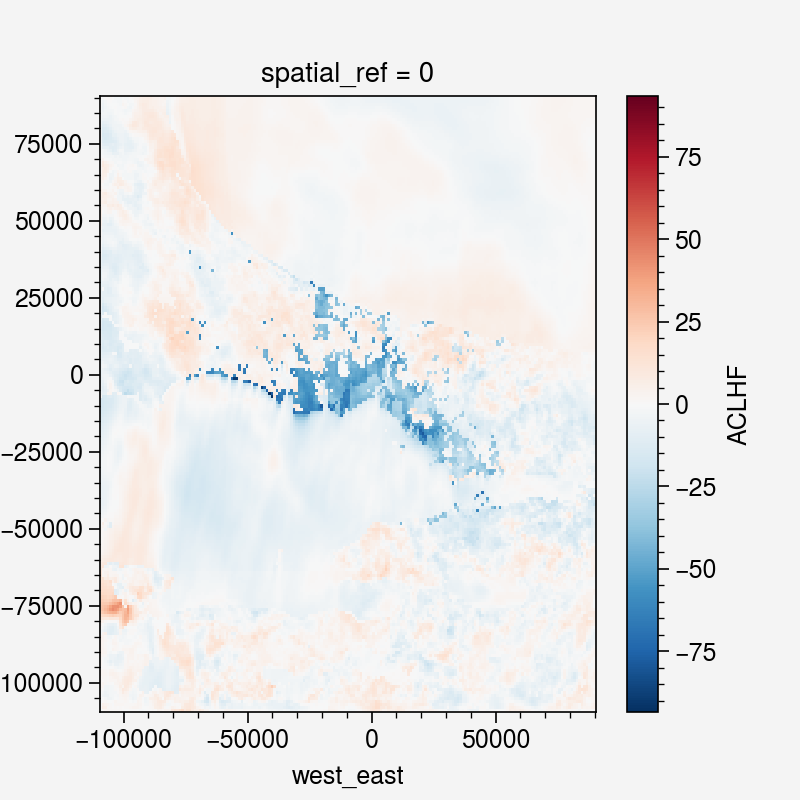

In [112]:
dt_ens_mean['era5'][2].plot()

## 3. Visualization

### 3.1 Open Land Use Datasets

In [108]:
luse_var = 'LU_INDEX'
urban_luse_border = xr.open_dataset(fr'{general_path}/wrfout_d03_LU_INDEX_urban.nc')[luse_var]
urban_luse_border = urban_luse_border.where(urban_luse_border==1, 0).isel(west_east = slice(35, 162),
                                                                          south_north = slice(57, 157))

### 3.2 Parameters

In [109]:
cmap = matplotlib.cm.seismic

In [110]:
# Parameters to change (plot) -------------------
# projection
proj = dt.rio.crs.to_dict()
globe = cartopy.crs.Globe(ellipse='sphere', semimajor_axis=6370000, semiminor_axis=6370000)
lcc = cartopy.crs.LambertConformal(globe=globe, # important!
                            central_longitude=proj['lon_0'], 
                            central_latitude=proj['lat_0'],
                            standard_parallels=(proj['lat_1'], proj['lat_2']),
                            )

# fig features
fig_array = [[1, 2, 3],
            # [4, 5, 6]
            ]
graphic_no = 3

### 4.3 Plot

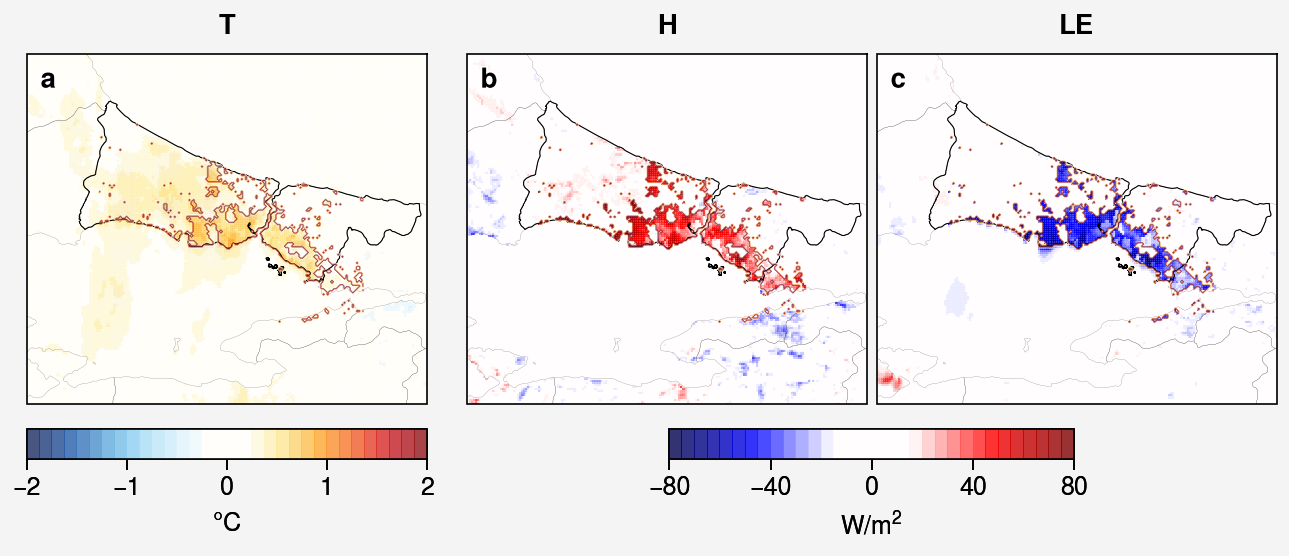

In [121]:
# Create Figure -------------------------
fig, axs = proplot.subplots(fig_array, 
                            aspect=4,
                            axwidth=2,
                            proj=lcc,
                            hratios=tuple(np.ones(len(fig_array), dtype=int)),
                            includepanels=True,
                            hspace=0.36,
                            wspace=[1.6, 0.4],
                            sharey=0)

# format whole figure
axs.format(abcloc='ul',
           abc=True,)

# istanbul limits
axs.format(lonlim=(27.69171143, 30.04271274-0.10),
           latlim=(40.08444595+0.20, 41.88309609-0.10),
           labels=False, 
           longrid=False, 
           latgrid = False)

axs.format(#rowlabels=['Spring', 'Summer'],
           collabels=['T', 'H', 'LE'],
           leftlabels_kw={'weight':'bold'},
           toplabels_kw={'weight':'bold'}
           )

proplot.rc.update({'leftlabel.rotation':'vertical'})

# add shapefiles
# add shapefiles
turkey_district_shape = r'data/shapefiles/istanbul_province_borders.shp'
shape_district_turkey = ShapelyFeature(Reader(turkey_district_shape).geometries(),
                                             cartopy.crs.PlateCarree(), facecolor='none',
                                             edgecolor = 'black', linewidth = 0.4, zorder = 0.3)

turkey_province_shape = r'data/shapefiles/Iller_HGK_6360_Kanun_Sonrasi.shp'
shape_province_turkey = ShapelyFeature(Reader(turkey_province_shape).geometries(),
                                             cartopy.crs.PlateCarree(), facecolor='none',
                                             edgecolor = 'black', linewidth = 0.05, zorder = 0.4)

for i in range(graphic_no):
    axs[i].add_feature(shape_district_turkey)
    axs[i].add_feature(shape_province_turkey)   
    
dt_border = urban_luse_border
for t in range(graphic_no):
            
    if t < 3:
        dt_season = dt_ens_mean['era5']
        #dt_border = urban_luse_border
        i = t
    else:
        pass
        #dt_season = dt_ens_mean['summer']
        #dt_border = nourban_luse_border
        #i = t-int(graphic_no/2)
    
    # colormap levels
    if i == 0:
        cmap = proplot.Colormap('ColdHot')
        clevs_total = np.arange(-2, 2.1, 0.125)
        ticks = np.arange(-2, 2.1, 1)
        col = 1
        label = '$°C$'
        shrink = 1
        cut = -0.1
        
    elif i in [1, 2]:
        cmap = matplotlib.cm.seismic
        clevs_total = np.arange(-80, 80.1, 5)
        ticks = np.arange(-80, 80.1, 40)
        col = [2, 3]
        label = '$W/m^2$'
        shrink = 0.5
        cut = -0.2
        
    # color norm
    norm = BoundaryNorm(clevs_total,
                        ncolors=cmap.N, 
                        clip=True)
    
    mesh = axs[t].pcolormesh(dt_season[i]['lon'], 
                            dt_season[i]['lat'],
                            dt_season[i], 
                            cmap = cmap,
                            cmap_kw={'cut': cut},
                            norm=norm,
                            zorder = 0.2,
                            alpha=0.8)
    
    if t in [0, 2]:
        # colorbar
        cbar = fig.colorbar(mesh,
                            label=label,
                            ticks = ticks,
                            loc = 'b',
                            col=col,
                            shrink=shrink,
                            width = 0.15
                           )
    
    # urban boundary contours
    contour = axs[t].contour(dt_border['lon'], 
                            dt_border['lat'],
                            dt_border,
                            linewidth = 0.1
                            )

#save figure
plt.savefig(r'pictures/T_H_LE_day_before_mean.jpeg',
            bbox_inches='tight', optimize=True,
            progressive=True, dpi=1000)